In [1]:
!pip install -q langchain sentencepiece plotly minijinja pyautogen markdownify pathvalidate puremagic mammoth python-pptx torchaudio pandas datasets google-search-results pydub easyocr pypdf

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from dotenv import load_dotenv
import datasets

load_dotenv(override=True)
pd.set_option("max_colwidth", None)

OUTPUT_DIR = "output_gaia"

/Users/aymeric/venvs/disposable/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from huggingface_hub import login
import os

login(os.getenv("HUGGINGFACEHUB_API_TOKEN"))

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/aymeric/.cache/huggingface/token
Login successful


In [5]:
from scripts.web_surfer import (
    browser,
    SearchInformationTool,
    NavigationalSearchTool,
    VisitTool,
    DownloadTool,
    PageUpTool,
    PageDownTool,
    FinderTool,
    FindNextTool,
)

WEB_TOOLS = [
    SearchInformationTool(),
    NavigationalSearchTool(),
    VisitTool(),
    DownloadTool(),
    PageUpTool(),
    PageDownTool(),
    FinderTool(),
    FindNextTool(),
]

In [6]:
from transformers.agents import HfEngine

llm_engine = HfEngine(model="meta-llama/Meta-Llama-3-70B-Instruct")

In [7]:
from datasets import concatenate_datasets

eval_ds = datasets.load_dataset("gaia-benchmark/GAIA", "2023_all")["validation"]
eval_ds = eval_ds.rename_columns(
    {"Question": "question", "Final answer": "true_answer", "Level": "task"}
)
# eval_ds_1 = eval_ds.filter(lambda x: (x["task"] in ["1"])).select(range(30))
# eval_ds_2 = eval_ds.filter(lambda x: (x["task"] in ["2"])).select(range(30))
# eval_ds = concatenate_datasets([eval_ds_1, eval_ds_2])


def preprocess_file_paths(row):
    if len(row["file_name"]) > 0:
        row["file_name"] = "data/gaia/validation/" + row["file_name"]
    return row


eval_ds = eval_ds.map(preprocess_file_paths)

eval_df = pd.DataFrame(eval_ds)

In [8]:
pd.Series(eval_ds["task"]).value_counts()

2    86
1    53
3    26
Name: count, dtype: int64

### Define tools

In [9]:
from transformers.agents import ReactJsonAgent, HfEngine

websurfer_llm_engine = HfEngine(
    model="CohereForAI/c4ai-command-r-plus"
)  # chosen for its high context length

surfer_agent = ReactJsonAgent(
    llm_engine=websurfer_llm_engine,
    tools=WEB_TOOLS,
    max_iterations=8,
    verbose=1,
)

In [10]:
cleaned_df = pd.read_json(
    "output_gaia/react_code_llama3-70b_02-05_full-gaia-validation-code.jsonl",
    lines=True,
)
print(len(cleaned_df))
cleaned_df = cleaned_df.loc[
    cleaned_df["intermediate_steps"].apply(
        lambda s: "Chat template must be a string" not in str(s)
        and "Model is overloaded." not in str(s)
        and "in 'if/else' conditions" not in str(s)
        # and "Stream has ended unexpectedly" not in str(s)
        and "Payload Too Large" not in str(s)
        and "Cannot read an empty file" not in str(s)
    )
]
print(len(cleaned_df))

# cleaned_df.to_json(
#     "output_gaia/react_code_llama3-70b_02-05_full-gaia-validation-code.jsonl",
#     orient="records",
#     lines=True,
# )

165
165


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


./data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png
{'inputs': 'User: What is the oldest Blu-Ray sold?<end_of_utterance>\nAssistant:', 'parameters': {'return_full_text': False, 'max_new_tokens': 200}}
{'generated_text': ' The oldest Blu-Ray sold is "The Keanu Reeves Story."'}
Density-Matrix Renormalization Group study of Many-body Localization in Floquet Eigenstates Carolyn Zhang,1, 2Frank Pollmann,1S. L. Sondhi,1, 3and Roderich Moessner

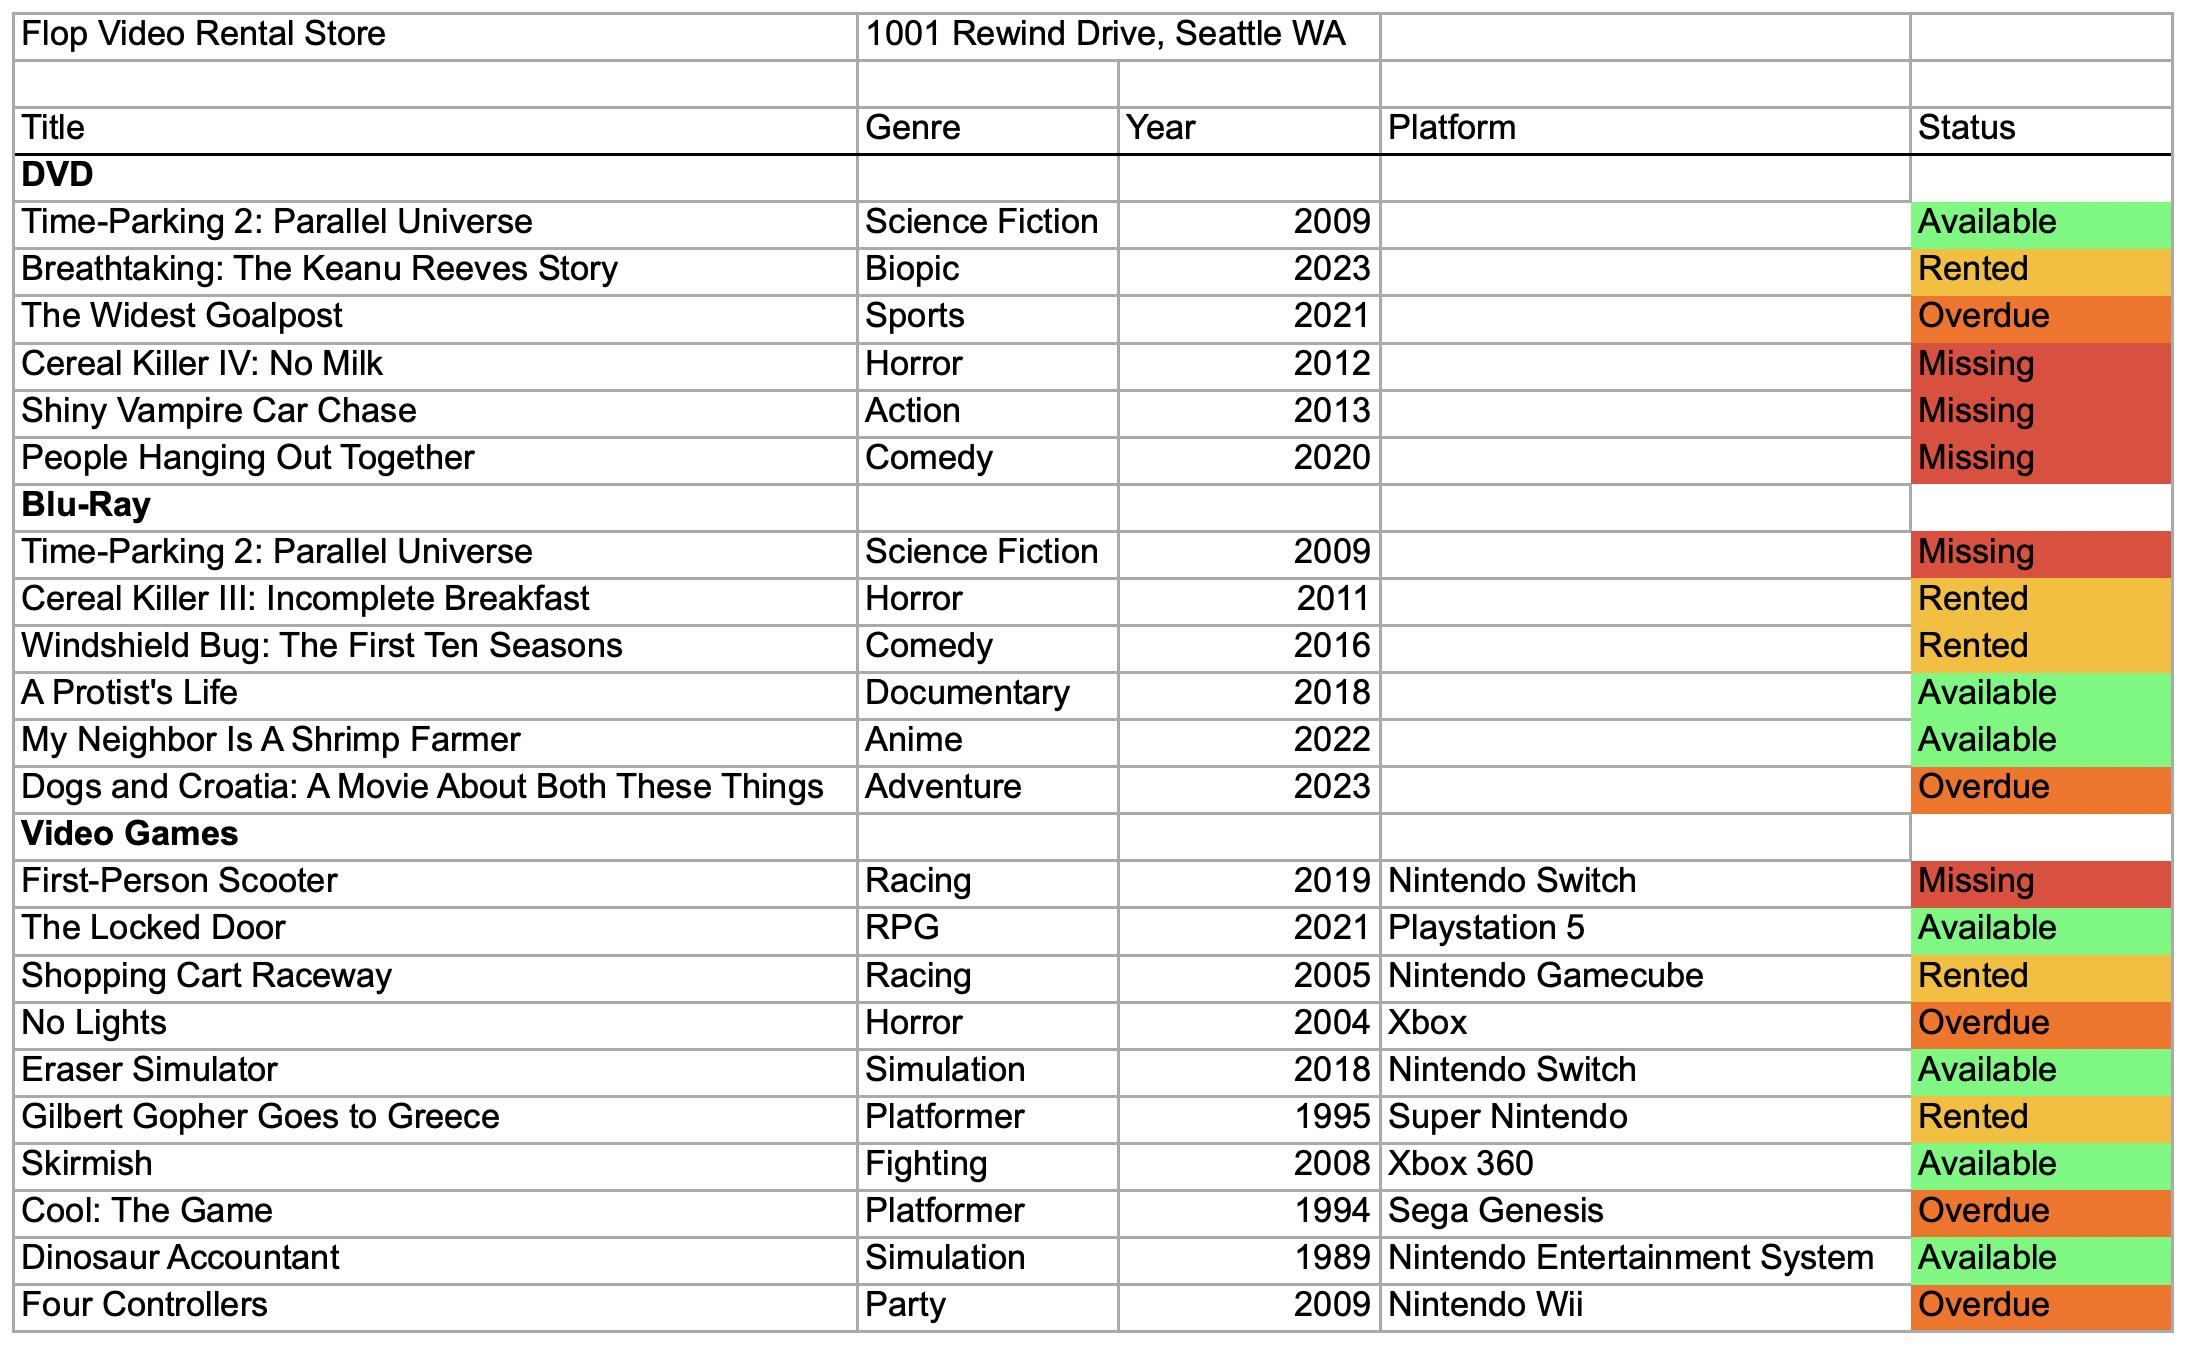

In [11]:
from transformers.agents.default_tools import Tool
from langchain_community.utilities import SerpAPIWrapper
from pypdf import PdfReader
from markdownify import markdownify as md
import requests
from huggingface_hub import InferenceClient
from scripts.visual_qa import process_images_and_text

params = {
    "engine": "bing",
    "gl": "us",
    "hl": "en",
}


class SearchTool(Tool):
    name = "ask_search_agent"
    description = "A search agent that will browse the internet to answer a question. Use it to gather informations, not for problem-solving."

    inputs = {
        "question": {
            "description": "Your question, as a natural language sentence. You are talking to an human, so provide them with as much context as possible!",
            "type": "text",
        }
    }
    output_type = "text"

    def forward(self, question: str) -> str:
        return surfer_agent.run(question)


def extract_text_from_pdf(pdf_path):
    pdf = PdfReader(pdf_path)
    text = ""
    for page in pdf.pages:
        text += page.extract_text()
    return md(text)


class TextInspectorTool(Tool):
    name = "inspect_file_as_text"
    description = "You cannot load files yourself: instead call this tool to read a file as text and ask questions about it."

    inputs = {
        "question": {
            "description": "Your question, as a natural language sentence. Provide as much context as possible.",
            "type": "text",
        },
        "file_path": {
            "description": "The path to the file you want to read as text. Must be a '.something' file, like '.pdf'. If it is an image, use the visualizer tool instead! If it's a webpage, use the web browser tool instead!",
            "type": "text",
        },
    }
    output_type = "text"

    def forward(self, question: str, file_path) -> str:
        if "http" in file_path:
            if "arxiv" in file_path:
                file_path = file_path.replace("abs", "pdf")
            response = requests.get(file_path)
            new_path = "/tmp/metadata.pdf"
            with open(new_path, "wb") as f:
                f.write(response.content)
                text = extract_text_from_pdf(new_path)
        elif file_path.split(".")[-1] == "pdf":
            text = extract_text_from_pdf(file_path)
        else:
            text = ""
            with open(file_path, "r") as f:
                while True:
                    line = f.readline()
                    if (not line) or (len(text) > 20000):
                        break
                    text += line

        messages = [
            {
                "role": "user",
                "content": "You will have to solve the following question with the below context: "
                + question,
            },
            {
                "role": "user",
                "content": "Here is the context:\n" + text,
            },
        ]
        return websurfer_llm_engine(messages)


from PIL import Image


def resize_image(image_path):
    img = Image.open(image_path)
    width, height = img.size
    img = img.resize((int(width / 2), int(height / 2)))
    new_image_path = f"resized_{image_path}"
    img.save(new_image_path)
    return new_image_path


class VisualQATool(Tool):
    name = "visualizer"
    description = "A tool that can answer questions about attached images."
    inputs = {
        "question": {"description": "the question to answer", "type": "text"},
        "image_path": {
            "description": "The path to the image on which to answer the question",
            "type": "text",
        },
    }
    output_type = "text"

    client = InferenceClient("HuggingFaceM4/idefics2-8b-chatty")

    def forward(self, question: str, image_path: str) -> str:
        try:
            return process_images_and_text(image_path, question, self.client)
        except Exception as e:
            print(e)
            if "Payload Too Large" in str(e):
                new_image_path = resize_image(image_path)
                return process_images_and_text(new_image_path, question, self.client)


# Let's test our tools!

visualizer = VisualQATool()
image_path = "./data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png"
print(visualizer(question="What is the oldest Blu-Ray sold?", image_path=image_path))

from transformers.agents import SpeechToTextTool

stt_tool = SpeechToTextTool()

# audio_path = "./data/gaia/validation/2b3ef98c-cc05-450b-a719-711aee40ac65.mp3"

# print(stt_tool(audio_path))


titool = TextInspectorTool()
print(
    titool(
        question="Could you cite the content at the beginning of page 4 of this document?",
        file_path="https://arxiv.org/pdf/1608.06411",
    )
)

In [12]:
from transformers.agents import PythonInterpreterTool

TASK_SOLVING_TOOLBOX = [
    SearchTool(),
    VisualQATool(),
    SpeechToTextTool(),
    TextInspectorTool(),
    # PythonInterpreterTool(),
]

# Define agents

In [13]:
from transformers.agents import ReactCodeAgent, HfEngine
from transformers.agents.prompts import DEFAULT_REACT_CODE_SYSTEM_PROMPT

GAIA_PROMPT = (
    DEFAULT_REACT_CODE_SYSTEM_PROMPT
    + """
Remember: Your $FINAL_ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings.
ADDITIONALLY, your $FINAL_ANSWER MUST adhere to any formatting instructions specified in the original question (e.g., alphabetization, sequencing, units, rounding, decimal places, etc.)
If you are asked for a number, express it numerically (i.e., with digits rather than words), don't use commas, and don't include units such as $ or percent signs unless specified otherwise.
If you are asked for a string, don't use articles or abbreviations (e.g. for cities), unless specified otherwise. Don't output any final sentence punctuation such as '.', '!', or '?'.
If you are asked for a comma separated list, apply the above rules depending on whether the elements are numbers or strings.
If you are unable to determine the final answer, use 'final_answer("Unable to determine")'
"""
)

llm_engine = HfEngine(model="meta-llama/Meta-Llama-3-70B-Instruct")
react_agent_hf = ReactCodeAgent(
    llm_engine=llm_engine,
    tools=TASK_SOLVING_TOOLBOX,
    max_iterations=7,
    verbose=0,
    memory_verbose=True,
    system_prompt=GAIA_PROMPT,
)

In [14]:
async def call_transformers(agent, question: str, **kwargs) -> str:
    result = agent.run(question, **kwargs)
    print(type(result))
    return {
        "output": str(result),
        "intermediate_steps": [
            {key: value for key, value in log.items() if key != "agent_memory"}
            for log in agent.logs
        ],
    }

In [15]:
assert False

AssertionError: 

In [16]:
res = await call_transformers(
    react_agent_hf,
    "What is the age  of the current prime minister of Guatemala, raised to the power 0.36?",
)
res

======== New task ========


What is the age  of the current prime minister of Guatemala, raised to the power 0.36?
==== Agent is executing the code below:
pm_info = ask_search_agent(question="Who is the current prime minister of Guatemala and how old are they?")
print(pm_info)
====
======== New task ========
Who is the current prime minister of Guatemala and how old are they?
Calling tool: 'informational_web_search' with arguments: {'query': 'prime minister of guatemala'}
Calling tool: 'informational_web_search' with arguments: {'query': 'Guatemala prime minister age'}
Calling tool: 'informational_web_search' with arguments: {'query': 'Biografía Bernardo Arévalo'}
Calling tool: 'final_answer' with arguments: {'answer': 'The current prime minister of Guatemala is Bernardo Arévalo. He was born on 7 October 1958 and is currently 65 years old.'}
Print outputs:
The current prime minister of Guatemala is Bernardo Arévalo. He was born on 7 October 1958 and is currently 65 years old.

==== Agent is executing the code bel

<class 'transformers.agents.agent_types.AgentText'>


{'output': '4.4941628807880765',
 'intermediate_steps': [{'system_prompt': 'You will be given a task to solve as best you can.\nTo do so, you have been given access to tools that are basically Python functions which you can call with code.\nTo solve the task, you must plan forward to proceed in a series of steps, in a cycle of \'Thought:\', \'Code:\', and \'Observation:\' sequences.\n\nAt each step, in the \'Thought:\' sequence, you should first explain your reasoning towards solving the task, then the tools that you want to use.\nThen in the \'Code:\' sequence, you should write the code in simple Python. The code sequence must end with \'<end_action>\' sequence.\nDuring each intermediate step, you can use \'print()\' to save whatever important information you will then need.\nThese print outputs will then appear in the \'Observation:\' field, which will be available as input for the next step.\nIn the end you have to return a final answer using the `final_answer` tool.\n\nHere are a f

In [ ]:
assert False

Found 1 previous results!


  0%|          | 0/165 [00:00<?, ?it/s]======== New task ========
I’m researching species that became invasive after people who kept them as pets released them. There’s a certain species of fish that was popularized as a pet by being the main character of the movie Finding Nemo. According to the USGS, where was this fish found as a nonnative species, before the year 2020? I need the answer formatted as the five-digit zip codes of the places the species was found, separated by commas if there is more than one place.
==== Agent is executing the code below:
answer = ask_search_agent(question="What is the name of the fish that is the main character of the movie Finding Nemo?")
print(answer)
====
======== New task ========
What is the name of the fish that is the main character of the movie Finding Nemo?
Calling tool: 'informational_web_search' with arguments: {'query': 'What is the name of the main character fish in Finding Nemo'}
Error in tool call execution: 'description'
You should only

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
num_articles = ask_search_agent(question="How many articles were published by Nature in 2020?")
print("Number of articles:", num_articles)
====
======== New task ========
How many articles were published by Nature in 2020?
Calling tool: 'informational_web_search' with arguments: {'query': 'How many articles did Nature publish in 2020?'}
Calling tool: 'visit_page' with arguments: {'url': 'https://www.nature.com/nature/articles?year=2020'}
Calling tool: 'visit_page' with arguments: {'url': 'https://www.nature.com/nbt/articles?year=2020'}
Calling tool: 'visit_page' with arguments: {'url': 'https://www.nature.com/srep/articles?year=2020'}
Calling tool: 'informational_web_search' with arguments: {'query': 'Number of articles published by Nature in 2020'}
Calling tool: 'informational_web_search' with arguments: {'query': 'Is Nature the same as Nature Medicine?'}
Error in tool call execution: 'description'
You should only use this tool with a correct in

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
answer = ask_search_agent(query="How to output a string in Unlambda?")
print(answer)
====
Failed while trying to execute the code below:
answer = ask_search_agent(query="How to output a string in Unlambda?")
print(answer)
This failed due to the following error:
SearchTool.forward() got an unexpected keyword argument 'query'
Traceback (most recent call last):
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/agents.py", line 870, in step
    result = self.python_evaluator(code_action, available_tools, state=self.state)
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/python_interpreter.py", line 511, in evaluate_python_code
    line_result = evaluate_ast(node, state, tools)
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/python_interpreter.py", line 360, in evaluate_ast
    return evaluate_assign(expressio

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
marathon_pace = ask_search_agent(question="What is Eliud Kipchoge's marathon world record time?")
print("Marathon pace:", marathon_pace)
moon_distance = ask_search_agent(question="What is the minimum perigee of the Moon according to Wikipedia?")
print("Moon distance:", moon_distance)
====
======== New task ========
What is Eliud Kipchoge's marathon world record time?
Calling tool: 'informational_web_search' with arguments: {'query': 'eliud kipchoge world record marathon time'}
Error in tool call execution: 'description'
You should only use this tool with a correct input.
As a reminder, this tool's description is the following:

- informational_web_search: Perform an INFORMATIONAL web search query then return the search results.
    Takes inputs: {'query': {'type': 'text', 'description': 'The informational web search query to perform.'}}
Traceback (most recent call last):
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
data = visualizer(question="What is the data in the spreadsheet?", image_path='data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png')
print(data)
====


data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png
{'inputs': 'User: What is the data in the spreadsheet?<end_of_utterance>\nAssistant:', 'parameters': {'return_full_text': False, 'max_new_tokens': 200}}

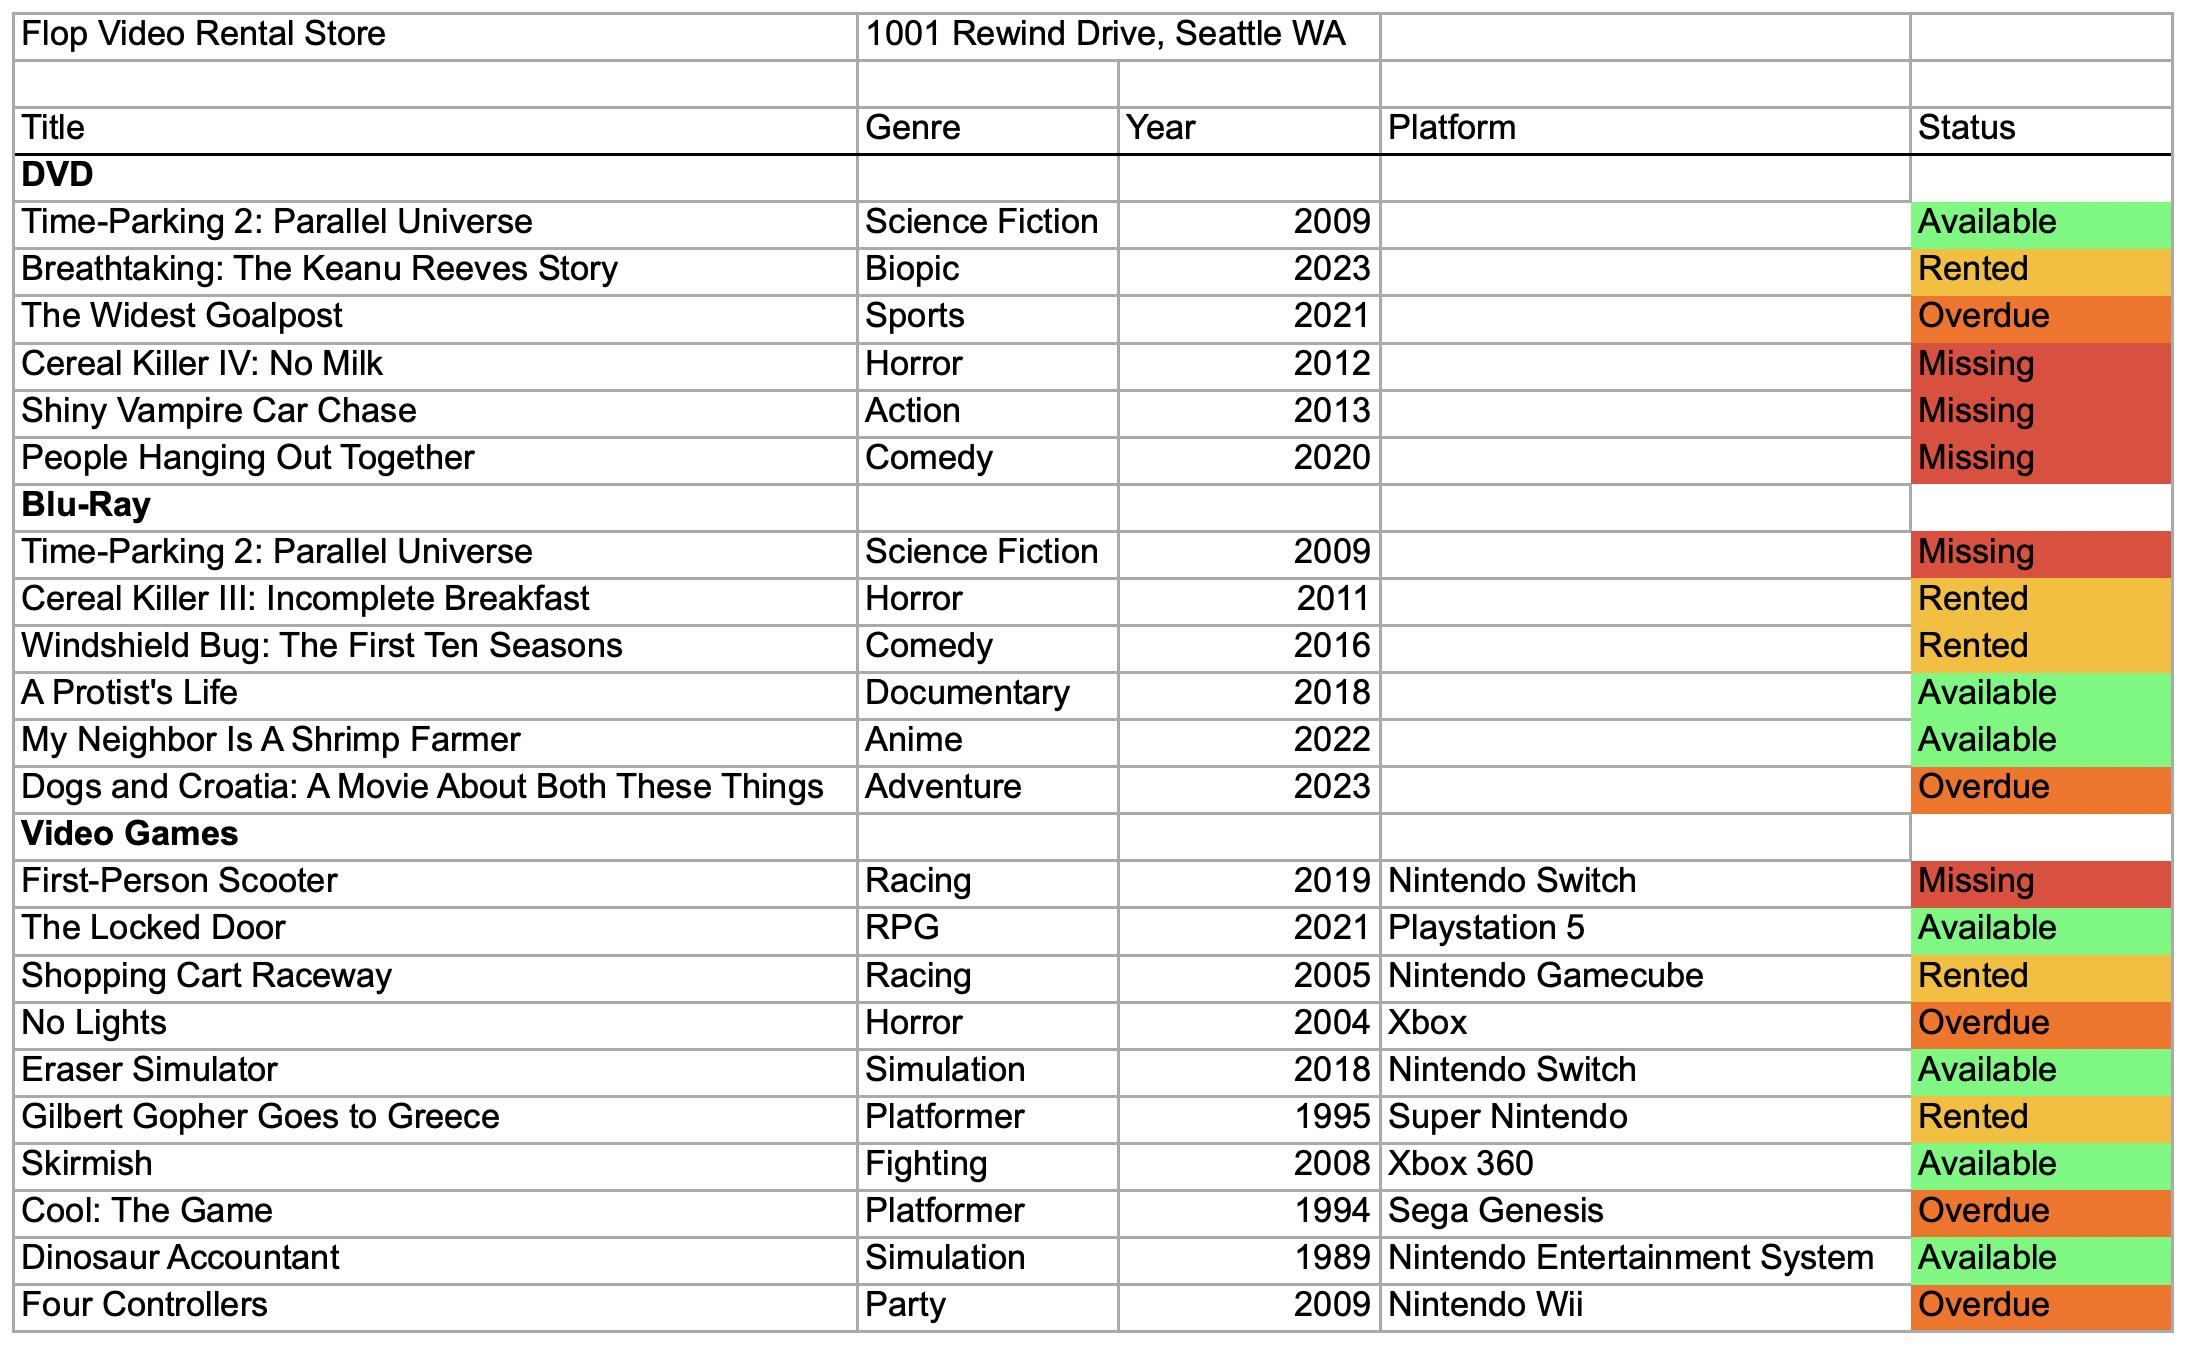

Print outputs:
{'generated_text': ' The data in the spreadsheet includes information about various video games, such as their titles, platforms, release years, and availability.'}

==== Agent is executing the code below:
titles = visualizer(question="What are the titles in the spreadsheet?", image_path='data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png')
 print(titles)
 formats = visualizer(question="What are the formats in the spreadsheet?", image_path='data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png')
 print(formats)
 years = visualizer(question="What are the release years in the spreadsheet?", image_path='data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png')
 print(years)
====
Failed while trying to execute the code below:
titles = visualizer(question="What are the titles in the spreadsheet?", image_path='data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png')
 print(titles)
 formats = visualizer(question="What are the formats in the sprea

data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png
{'inputs': 'User: What are the titles and release years of the Blu-Rays in the spreadsheet?<end_of_utterance>\nAssistant:', 'parameters': {'return_full_text': False, 'max_new_tokens': 200}}

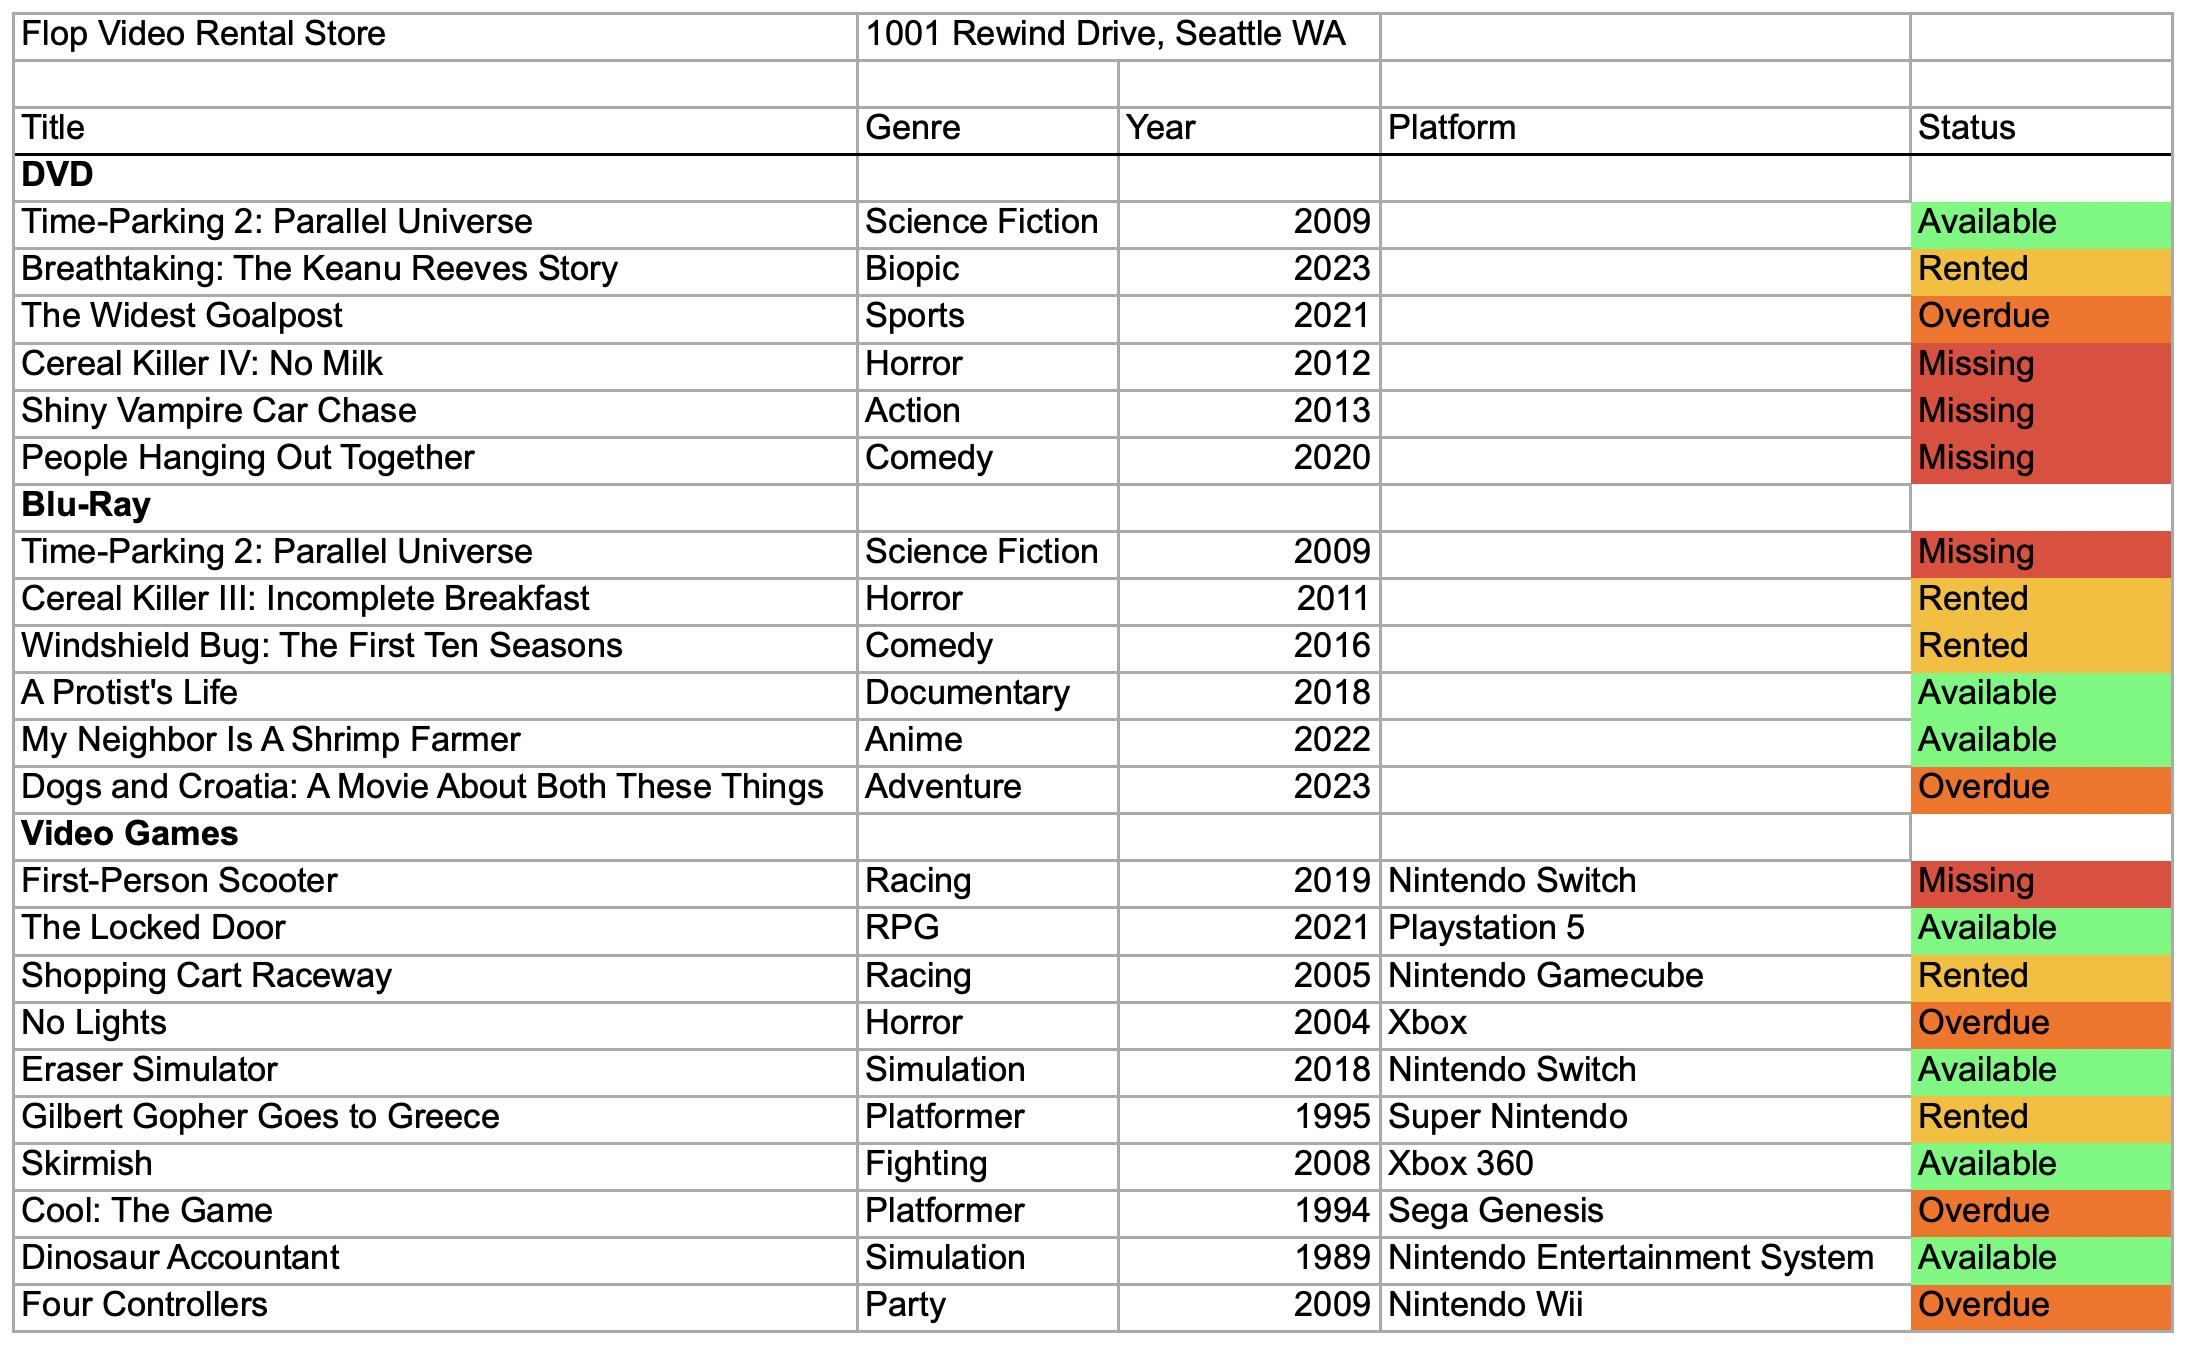

Print outputs:
{'generated_text': ' The Blu-Rays in the spreadsheet are "The Keanu Reeves Story," "The Locked Door," "The Windiest Goalpost," "The No Lights," "The Eraser Simulator," "The Skirmish," "The Cereal Killer III: Incomplete Breakfast," "The Windshield Bug: The First Ten Seasons," "The First-Person Scooter," "The Locked Door," "The Skirmish," "The Cereal Killer III: Incomplete Breakfast," "The Windshield Bug: The First Ten Seasons," "The First-Person Scooter," "The Locked Door," "The Skirmish," "The Cereal Killer III: Incomplete Breakfast," "The Windshield Bug: The First Ten Seasons," "The First-Person Scooter," "The Locked Door," "The Skirmish," "The C'}

==== Agent is executing the code below:
titles_years = visualizer(question="What are the titles and release years of the Blu-Rays in the spreadsheet?", image_path='data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png')
print(titles_years)
====
Print outputs:
{'generated_text': ' The Blu-Rays in the spreadsheet are "

data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png
{'inputs': 'User: What are the titles and release years of the Blu-Rays in the spreadsheet?<end_of_utterance>\nAssistant:', 'parameters': {'return_full_text': False, 'max_new_tokens': 200}}

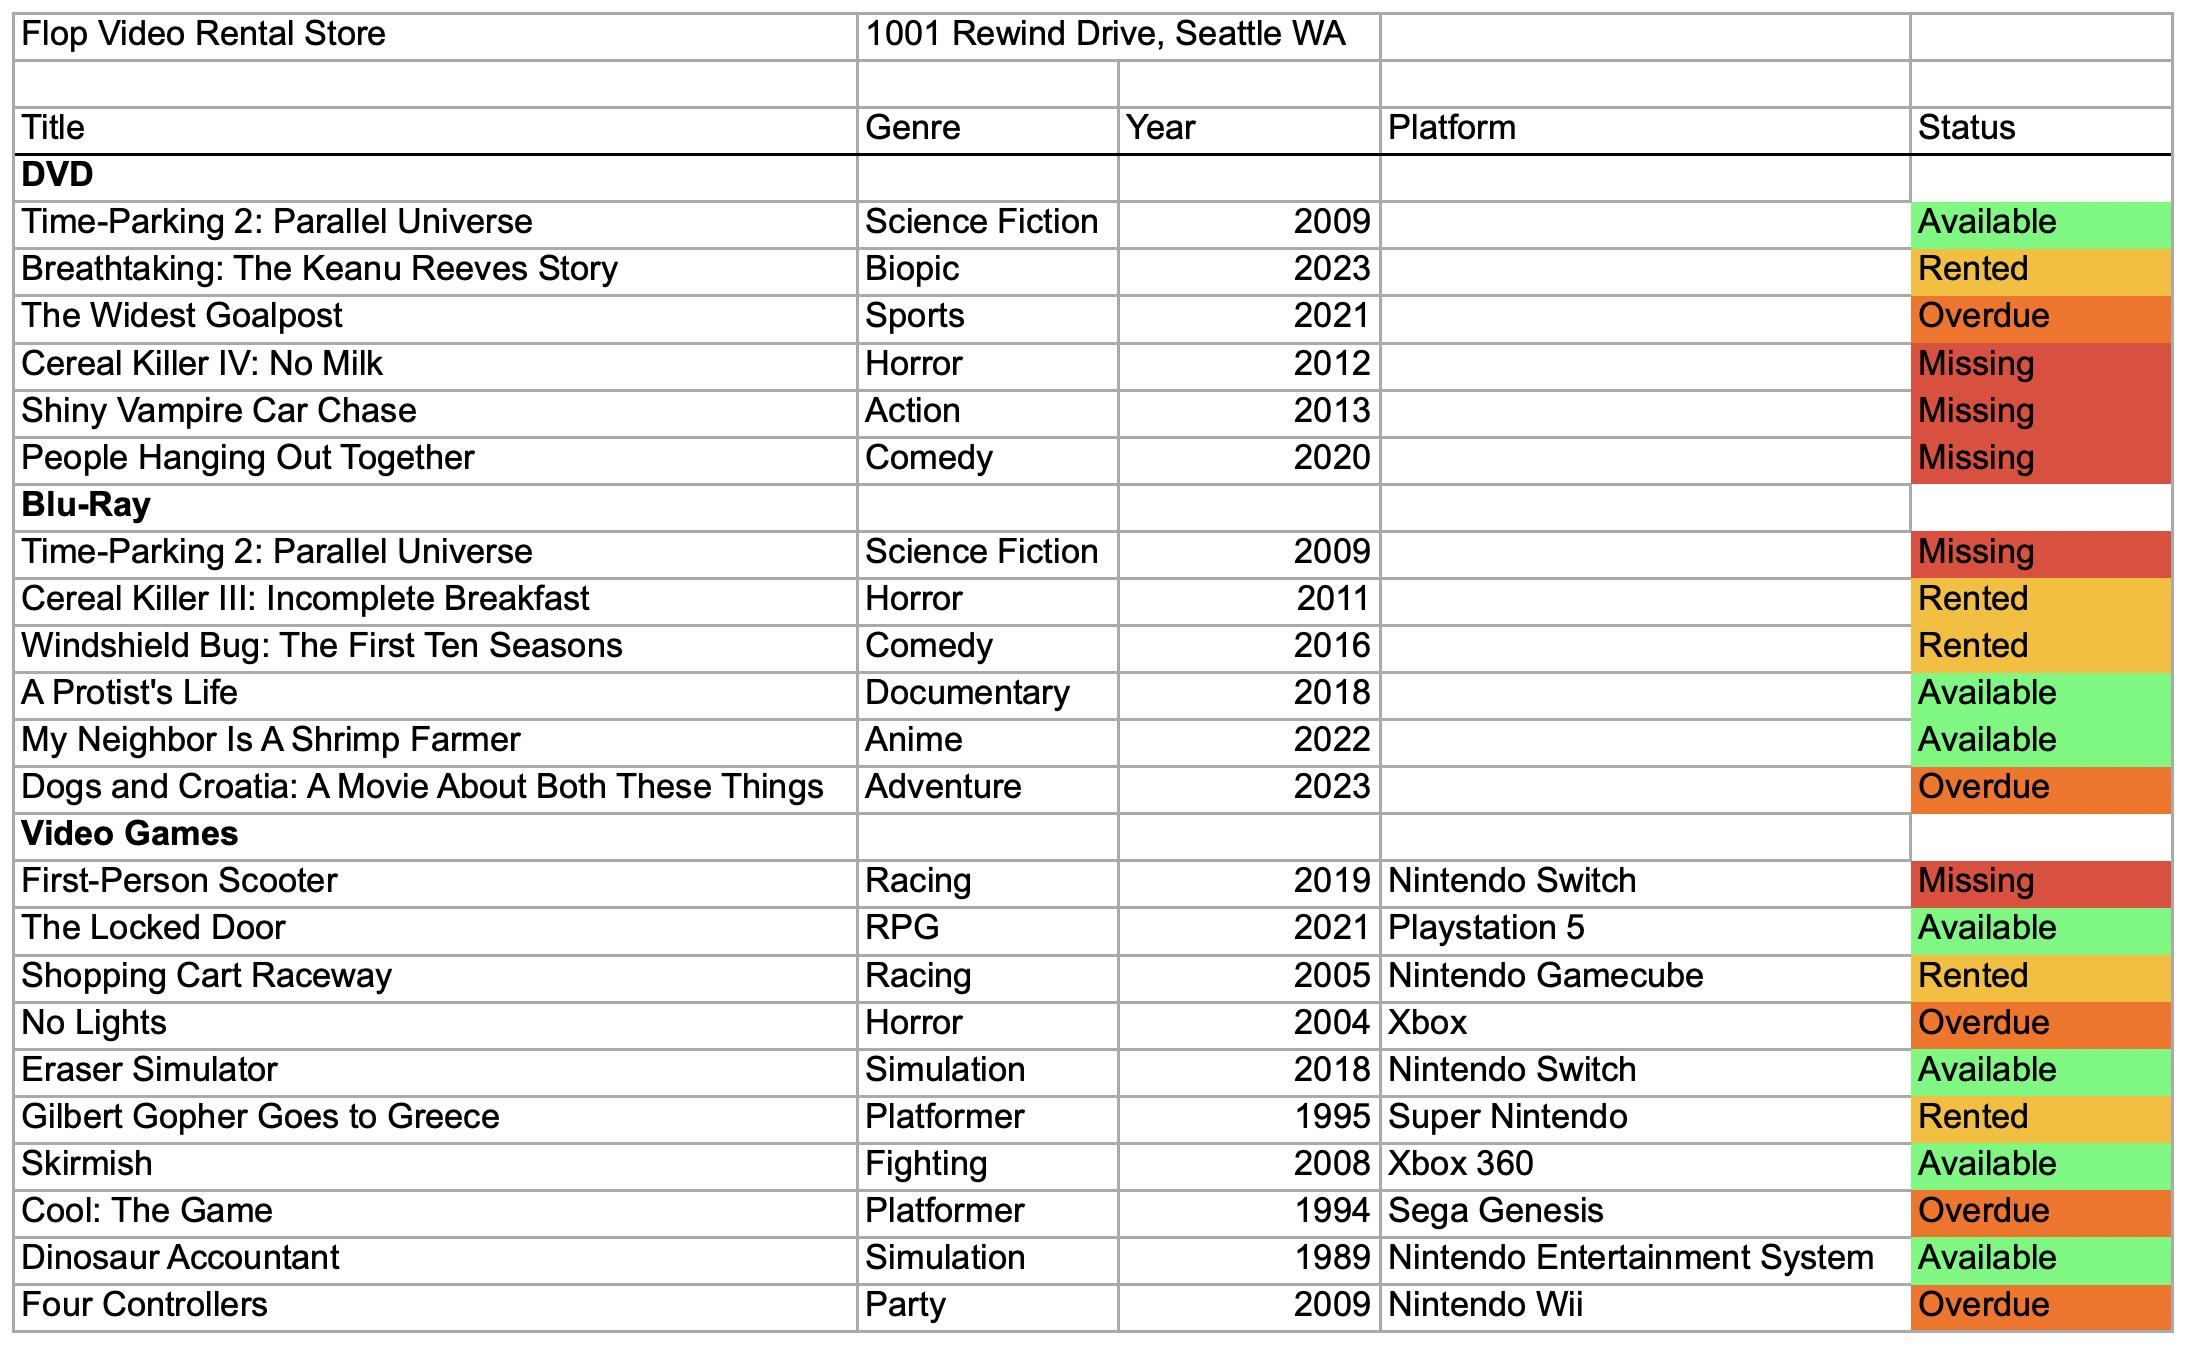

==== Agent is executing the code below:
answer = ask_search_agent(question="What is the release year of each of these movies: The Keanu Reeves Story, The Locked Door, The Windiest Goalpost, The No Lights, The Eraser Simulator, The Skirmish, The Cereal Killer III: Incomplete Breakfast, The Windshield Bug: The First Ten Seasons, The First-Person Scooter")
print(answer)
====
======== New task ========
What is the release year of each of these movies: The Keanu Reeves Story, The Locked Door, The Windiest Goalpost, The No Lights, The Eraser Simulator, The Skirmish, The Cereal Killer III: Incomplete Breakfast, The Windshield Bug: The First Ten Seasons, The First-Person Scooter
Could not parse the given action: The JSON blob you used is invalid: due to the following error: Extra data: line 6 column 6 (char 174). JSON blob was: {
        "action": "informational_web_search",
        "action_input": {
            "query": "What is the release year of the movie The Keanu Reeves Story?"
        }

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
answer = ask_search_agent(question="What are the studio albums of Mercedes Sosa, including their release years?")
print(answer)
====
======== New task ========
What are the studio albums of Mercedes Sosa, including their release years?
Calling tool: 'informational_web_search' with arguments: {'query': 'Mercedes Sosa Studio Albums'}
Error in tool call execution: 'description'
You should only use this tool with a correct input.
As a reminder, this tool's description is the following:

- informational_web_search: Perform an INFORMATIONAL web search query then return the search results.
    Takes inputs: {'query': {'type': 'text', 'description': 'The informational web search query to perform.'}}
Traceback (most recent call last):
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/agents.py", line 456, in execute_tool_call
    observation = self.toolbox.tools[tool_name](**arguments)
  File "/Users/aymeric/

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
article_info = ask_search_agent(question="Find the research article published in Science Advances in 2021 that talks about the mollusk species with the shell in the British Museum's collection with a museum number of 2012,5015.17.")
print("Article info:", article_info)
====
======== New task ========
Find the research article published in Science Advances in 2021 that talks about the mollusk species with the shell in the British Museum's collection with a museum number of 2012,5015.17.
Calling tool: 'informational_web_search' with arguments: {'query': 'Science Advances article in 2021 about mollusk in British Museum with museum number 2012,5015.17'}
Calling tool: 'find_on_page_ctrl_f' with arguments: {'search_string': 'Science Advances'}
Calling tool: 'visit_page' with arguments: {'url': 'https://www.britishmuseum.org/our-work/departments/scientific-research'}
Calling tool: 'visit_page' with arguments: {'url': 'https://phys.org/news/2021-10-speci

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
answer = ask_search_agent(query="Oldest closed numpy.polynomial issue with the Regression label on GitHub")
print(answer)
====
Failed while trying to execute the code below:
answer = ask_search_agent(query="Oldest closed numpy.polynomial issue with the Regression label on GitHub")
print(answer)
This failed due to the following error:
SearchTool.forward() got an unexpected keyword argument 'query'
Traceback (most recent call last):
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/agents.py", line 870, in step
    result = self.python_evaluator(code_action, available_tools, state=self.state)
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/python_interpreter.py", line 511, in evaluate_python_code
    line_result = evaluate_ast(node, state, tools)
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/python_inter

In [ ]:
from scripts.run_agents import answer_questions

results = await answer_questions(
    eval_ds,
    react_agent_hf,
    "react_code_llama3-70b_21-may_full-gaia-validation",
    output_folder=OUTPUT_DIR,
    agent_call_function=call_transformers,
    add_optional_visualizer_tool=True,
)

# Evaluate

In [ ]:
import glob

answer_file_path = f"{OUTPUT_DIR}/answers.jsonl"

result_df = pd.concat(
    [pd.read_json(f, lines=True) for f in glob.glob(f"{OUTPUT_DIR}/*llama3*.jsonl")]
)
result_df = result_df.drop(columns=["start_time", "end_time"])
result_df.to_json(answer_file_path, lines=True, orient="records")

In [ ]:
# display(result_df.loc[result_df["agent_name"] == "react_chat_zephyr"].head(5))

# display(result_df.loc[result_df["agent_name"] == "react_code_llama3-70b_29-04_reallybetterprompt", ["question", "prediction", "true_answer", "is_correct", "agent_memory"]])

In [ ]:
from scripts.gaia_scorer import question_scorer

result_df["is_correct"] = result_df.apply(
    lambda x: question_scorer(x["prediction"], x["true_answer"]), axis=1
)

Evaluating Failed by reaching max iterations. as a string.
Evaluating Let's try to answer the question manually.

According to Wikipedia, the Moon's perigee (closest approach) is approximately 356400 kilometers.

Eliud Kipchoge's record-making marathon pace is approximately 2.82 meters per second (source: Wikipedia).

Let's calculate the time it would take him to run the distance between the Earth and the Moon at its closest approach:

distance_to_moon = 356400 km = 356400000 m

speed = 2.82 m/s

time = distance / speed
= 356400000 m / (2.82 m/s)
= 126341818 s

 Convert seconds to hours:
= 126341818 s / 3600
= 35100 hours

Rounded to the nearest 1000 hours:
= 35100 hours ≈ 35000 hours

So, it would take Eliud Kipchoge approximately 35000 hours to run the distance between the Earth and the Moon at its closest approach, if he could maintain his record-making marathon pace indefinitely. as a number.
String Let's try to answer the question manually.

According to Wikipedia the Moon's perig

/Users/aymeric/Documents/Code/agent_reasoning_benchmark/scripts/gaia_scorer.py:56: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn(


In [ ]:
len(result_df)

1925

In [ ]:
def get_elements(x):
    output = x[0]["task"]
    for y in x[1:]:
        try:
            if "observation" in y:
                output += y["llm_output"] + "\nObservation:" + y["observation"]
            else:
                output += y["llm_output"] + "\Error:" + str(y["error"])
        except:
            pass
    return output


result_df["thoughts"] = result_df["intermediate_steps"].apply(lambda x: get_elements(x))

In [ ]:
agent_name = "react_code_llama3-70b_17-05_full-gaia-validation-cleaned"

display(
    result_df.loc[
        (result_df["agent_name"] == agent_name) & (result_df["is_correct"] == True),
        ["question", "prediction", "true_answer", "is_correct", "thoughts"],
    ]
)

,question,prediction,true_answer,is_correct,thoughts


### Aggregate evaluations

In [ ]:
result_df["intermediate_steps"].values[0][0].keys()

dict_keys(['system_prompt', 'task', 'agent_memory'])

In [ ]:
selection_name = "react_code_llama3-70b_06-05_full-gaia-validation-idefics"
submission_selection_name = "react_code_llama3-70b_02-05_full-gaia-validation-code"

result_df = result_df.loc[
    result_df["agent_name"].isin(
        [
            selection_name,
        ]
    )
]
len(result_df)

165

In [ ]:
result_df["task"].value_counts()

task
2    86
1    53
3    26
Name: count, dtype: int64

In [ ]:
# result_df.loc[result_df["true_answer"] == "Rd5"]

In [ ]:
tgt_string = "vale"
result_df.loc[result_df["question"].str.contains(tgt_string)][
    ["prediction", "true_answer"]
]

,prediction,true_answer
39,(¬A → B) ↔ (A ∨ ¬B),(¬A → B) ↔ (A ∨ ¬B)


In [ ]:
result_df["true_answer_in_prediction"] = result_df.apply(
    lambda x: x["true_answer"] in x["prediction"], axis=1
)

In [ ]:
result_df.loc[
    result_df["true_answer_in_prediction"] & ~result_df["is_correct"],
    ["question", "prediction", "true_answer", "is_correct", "thoughts"],
].head(10)

question  \
9   Here's a fun riddle that I think you'll enjoy.\n\nYou have been selected to play the final round of the hit new game show "Pick That Ping-Pong". In this round, you will be competing for a large cash prize. Your job will be to pick one of several different numbered ping-pong balls, and then the game will commence. The host describes how the game works.\n\nA device consisting of a winding clear ramp and a series of pistons controls the outcome of the game. The ramp feeds balls onto a platform. The platform has room for three ping-pong balls at a time. The three balls on the platform are each aligned with one of three pistons. At each stage of the game, one of the three pistons will randomly fire, ejecting the ball it strikes. If the piston ejects the ball in the first position on the platform the balls in the second and third position on the platform each advance one space, and the next ball on the ramp advances to the third position. If the piston ejects the ball in the second position, the ball in the first position is released and rolls away, the ball in the third position advances two spaces to occupy the first position, and the next two balls on the ramp advance to occupy the second and third positions on the platform. If the piston ejects the ball in the third position, the ball in the first position is released and rolls away, the ball in the second position advances one space to occupy the first position, and the next two balls on the ramp advance to occupy the second and third positions on the platform.\n\nThe ramp begins with 100 numbered ping-pong balls, arranged in ascending order from 1 to 100. The host activates the machine and the first three balls, numbered 1, 2, and 3, advance to the platform. Before the random firing of the pistons begins, you are asked which of the 100 balls you would like to pick. If your pick is ejected by one of the pistons, you win the grand prize, $10,000.\n\nWhich ball should you choose to maximize your odds of winning the big prize? Please provide your answer as the number of the ball selected.   
22                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      In Series 9, Episode 11 of Doctor Who, the Doctor is trapped i

In [ ]:
result_df.groupby(["agent_name", "task"])["is_correct"].mean()

agent_name                                                           task
react_code_llama3-70b_02-05_full-gaia-validation-code                1       0.301887
                                                                     2       0.116279
                                                                     3       0.076923
react_code_llama3-70b_06-05_full-gaia-validation-idefics             1       0.132075
                                                                     2       0.046512
                                                                     3       0.076923
react_code_llama3-70b_06-05_full-gaia-validation-idefics-gaiaprompt  1       0.204082
                                                                     2       0.085366
                                                                     3       0.043478
react_code_llama3-70b_07-05_full-gaia-validation                     1       0.100000
                                                                  

In [ ]:
result_df.groupby(["agent_name"])["is_correct"].mean()

agent_name
react_code_llama3-70b_06-05_full-gaia-validation-idefics    0.078788
Name: is_correct, dtype: float64

In [ ]:
df_inspect = result_df.loc[
    result_df["agent_name"] == "react_code_llama3_26-04-final_answer"
]

In [ ]:
logs = list(df_inspect["intermediate_steps"].values)
memories = [log[-2]["agent_memory"] for log in logs if "agent_memory" in log[-2]]

error_memories = [memory for memory in memories if "error" in str(memory).lower()]
error_memories

In [ ]:
error_memories

In [ ]:
result_df.keys()